In [1]:
# !pip install scikit-image==0.19.1
# !pip install ipywidgets --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org

In [2]:
import torch
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

In [3]:
# List of available models in PyTorch Hub from Nvidia/DeepLearningExamples
torch.hub.list('NVIDIA/DeepLearningExamples:torchhub')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


['nvidia_convnets_processing_utils',
 'nvidia_efficientnet',
 'nvidia_efficientnet_b0',
 'nvidia_efficientnet_b4',
 'nvidia_efficientnet_widese_b0',
 'nvidia_efficientnet_widese_b4',
 'nvidia_gpunet',
 'nvidia_resneXt',
 'nvidia_resnet50',
 'nvidia_resnext101_32x4d',
 'nvidia_se_resnext101_32x4d',
 'nvidia_ssd',
 'nvidia_ssd_processing_utils',
 'nvidia_tacotron2',
 'nvidia_tts_utils',
 'nvidia_waveglow']

Model Description

In [4]:
# load SSD model pretrained on COCO from Torch Hub
precision = 'fp32'
ssd300 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision);

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:207: UserWarning: The parameter 'pretrained' is deprecated, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:220: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sample Inference

In [5]:
# Sample images from the COCO validation set
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

# For convenient and comprehensive formatting of input and output of the model, load a set of utility methods.
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

# Format images to comply with the network input
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, False)

# The model was trained on COCO dataset, which we need to access in order to
# translate class IDs into object names. 
classes_to_labels = utils.get_coco_object_dictionary()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [6]:
# Next, we run object detection
model = ssd300.eval().to("cuda")
detections_batch = model(tensor)

# By default, raw output from SSD network per input image contains 8732 boxes with 
# localization and class probability distribution. 
# Let’s filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

Visualize results

In [7]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# The utility plots the images and predicted bounding boxes (with confidence scores).
def plot_results(best_results):
    for image_idx in range(len(best_results)):
        fig, ax = plt.subplots(1)
        # Show original, denormalized image...
        image = inputs[image_idx] / 2 + 0.5
        ax.imshow(image)
        # ...with detections
        bboxes, classes, confidences = best_results[image_idx]
        for idx in range(len(bboxes)):
            left, bot, right, top = bboxes[idx]
            x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

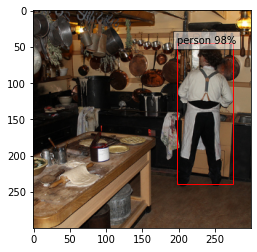

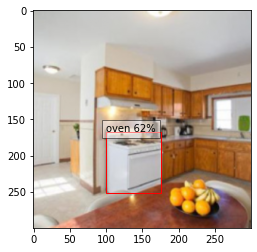

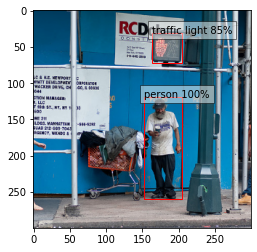

In [8]:
# Visualize results without Torch-TensorRT
plot_results(best_results_per_input)

Benchmark utility

Torch TensorRT

In [9]:
import time
import numpy as np

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

# Helper function to benchmark the model
def benchmark(model, input_shape=(1024, 1, 32, 32), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc, pred_label  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output location prediction size:", pred_loc.size())
    print("Output label prediction size:", pred_label.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

In [10]:
# Model benchmark without Torch-TensorRT
model = ssd300.eval().to("cuda")
benchmark(model, input_shape=(128, 3, 300, 300), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, avg batch time 414.80 ms
Iteration 20/100, avg batch time 414.90 ms
Iteration 30/100, avg batch time 415.15 ms
Iteration 40/100, avg batch time 415.39 ms
Iteration 50/100, avg batch time 415.51 ms
Iteration 60/100, avg batch time 415.64 ms
Iteration 70/100, avg batch time 415.74 ms
Iteration 80/100, avg batch time 415.87 ms
Iteration 90/100, avg batch time 416.00 ms
Iteration 100/100, avg batch time 416.16 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([128, 4, 8732])
Output label prediction size: torch.Size([128, 81, 8732])
Average batch time: 416.16 ms


Creating TorchScript modules

In [11]:
model = ssd300.eval().to("cuda")
traced_model = torch.jit.trace(model, [torch.randn((1,3,300,300)).to("cuda")])

In [12]:
torch.jit.save(traced_model, "ssd_300_traced.jit.pt")

In [13]:
model_saved = torch.load('ssd_300_traced.jit.pt')
model_saved.state_dict()

/opt/conda/lib/python3.8/site-packages/torch/serialization.py:707: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


OrderedDict([('feature_extractor.feature_extractor.0.weight',
              tensor([[[[ 6.6071e-03, -1.9562e-02, -2.5208e-02,  ..., -3.0624e-02,
                         -1.7899e-02,  1.6129e-02],
                        [-5.0812e-03, -4.1122e-03, -1.0742e-02,  ..., -4.3640e-02,
                         -4.9622e-02, -2.3239e-02],
                        [ 3.8788e-02,  2.5711e-02,  5.3467e-02,  ...,  5.7343e-02,
                          3.1525e-02,  2.3926e-02],
                        ...,
                        [-9.2926e-03,  1.6418e-02,  1.6037e-02,  ..., -4.0314e-02,
                         -7.9803e-03,  2.6642e-02],
                        [ 3.1242e-03,  1.6190e-02,  5.7434e-02,  ...,  2.7084e-02,
                         -4.3221e-03,  1.0666e-02],
                        [-3.5950e-02, -4.5105e-02, -5.9784e-02,  ..., -9.8648e-03,
                         -2.6367e-02,  2.1496e-03]],
              
                       [[ 1.1963e-02, -7.0152e-03,  7.7744e-03,  ...,  5.9395e-03,


In [14]:
# Obtain the average time taken by a batch of input with Torchscript compiled modules
benchmark(traced_model, input_shape=(128, 3, 300, 300), nruns=100)

Warm up ...
Start timing ...
Iteration 10/100, avg batch time 417.77 ms
Iteration 20/100, avg batch time 417.73 ms
Iteration 30/100, avg batch time 417.89 ms
Iteration 40/100, avg batch time 418.03 ms
Iteration 50/100, avg batch time 418.13 ms
Iteration 60/100, avg batch time 418.25 ms
Iteration 70/100, avg batch time 418.35 ms
Iteration 80/100, avg batch time 418.45 ms
Iteration 90/100, avg batch time 418.52 ms
Iteration 100/100, avg batch time 418.60 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([128, 4, 8732])
Output label prediction size: torch.Size([128, 81, 8732])
Average batch time: 418.60 ms


Compiling with Torch-TensorRT

In [15]:
import torch_tensorrt

# The compiled module will have precision as specified by "op_precision".
# Here, it will have FP16 precision.    
trt_model = torch_tensorrt.compile(traced_model, 
    inputs= [torch_tensorrt.Input((3, 3, 300, 300), dtype=torch.half)],
    enabled_precisions= {torch.half}, # Run with FP16
    workspace_size= 1 << 20
)

The compiler is going to use the user setting Float16
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x
- Disable partial compilation by setting require_full_compilation to True


Running Inference

In [16]:
# using a Torch-TensorRT module is exactly the same as how we usually do inference in PyTorch i.e. model(inputs)
detections_batch = trt_model(tensor.to(torch.half)) # convert the input to half precision

# By default, raw output from SSD network per input image contains 8732 boxes with 
# localization and class probability distribution. 
# Let’s filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.
results_per_input = utils.decode_results(detections_batch)
best_results_per_input_trt = [utils.pick_best(results, 0.40) for results in results_per_input]

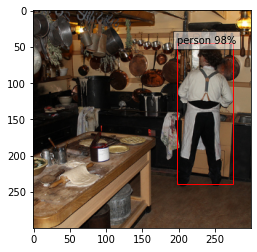

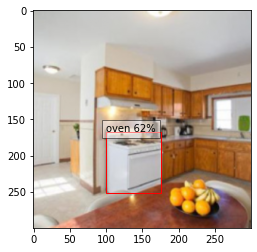

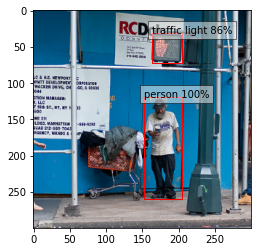

In [17]:
# Visualize results with Torch-TensorRT
plot_results(best_results_per_input_trt)

---

Measuring SpeedUp

In [18]:
batch_size = 128

# Recompiling with batch_size we use for evaluating performance
trt_model = torch_tensorrt.compile(traced_model,
    inputs = [torch_tensorrt.Input((batch_size, 3, 300, 300), dtype=torch.half)],
    enabled_precisions= {torch.half}, # Run with FP16
    workspace_size= 1 << 20
)

benchmark(trt_model, input_shape=(batch_size, 3, 300, 300), dtype='fp16', nruns=100)

The compiler is going to use the user setting Float16
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x
- Disable partial compilation by setting require_full_compilation to True


Warm up ...
Start timing ...
Iteration 10/100, avg batch time 78.30 ms
Iteration 20/100, avg batch time 77.97 ms
Iteration 30/100, avg batch time 77.81 ms
Iteration 40/100, avg batch time 77.78 ms
Iteration 50/100, avg batch time 77.64 ms
Iteration 60/100, avg batch time 77.55 ms
Iteration 70/100, avg batch time 77.64 ms
Iteration 80/100, avg batch time 77.58 ms
Iteration 90/100, avg batch time 77.53 ms
Iteration 100/100, avg batch time 77.49 ms
Input shape: torch.Size([128, 3, 300, 300])
Output location prediction size: torch.Size([128, 4, 8732])
Output label prediction size: torch.Size([128, 81, 8732])
Average batch time: 77.49 ms


---

In [19]:
import os

def print_model_size(model):
    torch.save(model.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [22]:
print_model_size(model)   # Original
print_model_size(trt_model)   # Optimized

91.85 MB
91.85 MB
